In [8]:
'''
Daniel Qu, Teresa Tamayo-Mendoza
AM 221
Code inspired from:

DCGAN on MNIST using Keras
Author: Rowel Atienza
Project: https://github.com/roatienza/Deep-Learning-Experiments
Dependencies: tensorflow 1.0 and keras 2.0
Usage: python3 dcgan_mnist.py
'''

import numpy as np
import time
from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

NUMCHARS = 11
MAXLEN = 23

char_to_int = {"C": 0, ")": 1, "(": 2, "#": 3, "1": 4, "3": 5, "2": 6, "5": 7, "4": 8, "=": 9, "_": 10}
int_to_char = {}

for (key, value) in char_to_int.items():
    int_to_char[value] = key

def convert_to_string(mat):
    ret = ""
    for column in mat.T:
        if max(column) == 0:
            continue
        biggest = np.argmax(column)
        if biggest == NUMCHARS - 1:
            continue
        ret += int_to_char[biggest]
    return ret

def smooth(mat, epsilon):
    ret = []
    for column in mat.T:
        n = len(column)
        if sum(column) == 0:
            ret.append(np.zeros(n))
            continue
        new = []
        for entry in column:
            if entry == 1:
                new.append(entry - epsilon)
            else:
                new.append(epsilon / (n - 1))
        ret.append(new)
    return np.array(ret).T

data = np.load("alkanes.npy")
X = []
for line in data:
    X.append(np.reshape(line, (MAXLEN, NUMCHARS)).T)
    
epsilon = 0.1
    
for i in range(1):
    sample = X[i]
    print(sample)
#     print(smooth(sample, epsilon))
    print(convert_to_string(sample))
    

# add noise to discriminator input, decay noise with time?

def tex(mat):
    ret = ""
    for line in mat:
        for entry in line:
            ret += str(entry) + " & "
        ret += "\\\\"
        ret += "\n"
    return ret

print(tex(X[0]))

[[1 1 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]]
CC1=CC=CC(C)=C1C
1 & 1 & 0 & 0 & 1 & 1 & 0 & 1 & 1 & 0 & 1 & 0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 &

In [30]:
GENERATED = []

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=NUMCHARS + 1, img_cols=MAXLEN + 1, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model


    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.3
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

#         self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
#         self.D.add(LeakyReLU(alpha=0.2))
#         self.D.add(Dropout(dropout))

#         self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
#         self.D.add(LeakyReLU(alpha=0.2))
#         self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.3
        depth = 64+64+64+64
        dim_1 = int(np.ceil(NUMCHARS / 4))
        dim_2 = int(np.ceil(MAXLEN / 4))
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim_1*dim_2*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim_1, dim_2, depth)))
        self.G.add(Dropout(dropout))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        # change to adam?
        optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = NUMCHARS + 1
        self.img_cols = MAXLEN + 1
        self.channel = 1
        self.disc_losses = []
        self.gen_losses = []

        X = []
        data = np.load("alkanes.npy")[:2048]
        for line in data:
            new = np.reshape(line, (MAXLEN, NUMCHARS)).T
            new = np.vstack((new, np.zeros(MAXLEN)))
            new = np.hstack((new, np.zeros((NUMCHARS + 1, 1))))
            X.append(smooth(new, epsilon))
        self.x_train = np.array(X).reshape(-1, NUMCHARS + 1, MAXLEN + 1, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=1000, batch_size=128, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(0.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(0.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)
            
#             if i > 0:
#                 if a_loss[1] < 0.025:
#                     y = np.ones([batch_size, 1])
#                     noise = np.random.uniform(0.0, 1.0, size=[batch_size, 100])
#                     a_loss = self.adversarial.train_on_batch(noise, y)
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(0.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            self.disc_losses.append(d_loss[0])
            self.gen_losses.append(a_loss[0])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    noise = np.random.uniform(0.0, 1.0, size=[10, 100])
                    images = self.generator.predict(noise)
                    GENERATED.append(images)

if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    timer = ElapsedTimer()
    steps = 500
    mnist_dcgan.train(train_steps=steps, batch_size=128, save_interval=100)
    timer.elapsed_time()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 6, 12, 64)         1664      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 6, 12, 64)         0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 6, 12, 64)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 3, 6, 128)         0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 3, 6, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2304)              0         
__________

55: [D loss: 0.333848, acc: 0.972656]  [A loss: 1.643876, acc: 0.000000]
56: [D loss: 0.352974, acc: 0.972656]  [A loss: 1.694229, acc: 0.000000]
57: [D loss: 0.310990, acc: 0.988281]  [A loss: 1.796386, acc: 0.000000]
58: [D loss: 0.258764, acc: 1.000000]  [A loss: 1.525250, acc: 0.000000]
59: [D loss: 0.380398, acc: 0.839844]  [A loss: 2.330662, acc: 0.000000]
60: [D loss: 0.328140, acc: 0.996094]  [A loss: 1.041507, acc: 0.007812]
61: [D loss: 0.637032, acc: 0.500000]  [A loss: 1.683642, acc: 0.000000]
62: [D loss: 0.494520, acc: 0.816406]  [A loss: 0.749008, acc: 0.367188]
63: [D loss: 0.833677, acc: 0.433594]  [A loss: 1.771343, acc: 0.000000]
64: [D loss: 0.632089, acc: 0.718750]  [A loss: 1.098801, acc: 0.000000]
65: [D loss: 0.667169, acc: 0.484375]  [A loss: 1.734233, acc: 0.000000]
66: [D loss: 0.575152, acc: 0.820312]  [A loss: 1.105397, acc: 0.000000]
67: [D loss: 0.613848, acc: 0.515625]  [A loss: 1.915534, acc: 0.000000]
68: [D loss: 0.469616, acc: 0.863281]  [A loss: 1.0

167: [D loss: 0.537854, acc: 0.671875]  [A loss: 1.936297, acc: 0.000000]
168: [D loss: 0.413226, acc: 0.894531]  [A loss: 1.144629, acc: 0.156250]
169: [D loss: 0.522942, acc: 0.660156]  [A loss: 2.053113, acc: 0.000000]
170: [D loss: 0.413120, acc: 0.882812]  [A loss: 1.132554, acc: 0.164062]
171: [D loss: 0.481911, acc: 0.714844]  [A loss: 2.141959, acc: 0.000000]
172: [D loss: 0.361832, acc: 0.906250]  [A loss: 1.427312, acc: 0.023438]
173: [D loss: 0.462509, acc: 0.773438]  [A loss: 2.052840, acc: 0.000000]
174: [D loss: 0.406225, acc: 0.867188]  [A loss: 1.490224, acc: 0.023438]
175: [D loss: 0.933333, acc: 0.589844]  [A loss: 2.449187, acc: 0.000000]
176: [D loss: 1.422307, acc: 0.191406]  [A loss: 2.368757, acc: 0.000000]
177: [D loss: 1.144376, acc: 0.226562]  [A loss: 1.367906, acc: 0.054688]
178: [D loss: 1.168979, acc: 0.203125]  [A loss: 2.197627, acc: 0.000000]
179: [D loss: 0.882998, acc: 0.410156]  [A loss: 1.209328, acc: 0.117188]
180: [D loss: 1.131648, acc: 0.351562]

278: [D loss: 0.399147, acc: 0.867188]  [A loss: 1.601343, acc: 0.000000]
279: [D loss: 0.425364, acc: 0.828125]  [A loss: 1.948880, acc: 0.007812]
280: [D loss: 0.371470, acc: 0.867188]  [A loss: 1.512353, acc: 0.015625]
281: [D loss: 0.408567, acc: 0.843750]  [A loss: 2.120075, acc: 0.000000]
282: [D loss: 0.363542, acc: 0.843750]  [A loss: 1.355899, acc: 0.054688]
283: [D loss: 0.418344, acc: 0.777344]  [A loss: 2.471838, acc: 0.000000]
284: [D loss: 0.281276, acc: 0.929688]  [A loss: 1.238841, acc: 0.070312]
285: [D loss: 0.406453, acc: 0.785156]  [A loss: 2.346325, acc: 0.000000]
286: [D loss: 0.293991, acc: 0.910156]  [A loss: 0.790503, acc: 0.406250]
287: [D loss: 0.798918, acc: 0.519531]  [A loss: 2.680184, acc: 0.000000]
288: [D loss: 0.388926, acc: 0.835938]  [A loss: 1.024309, acc: 0.351562]
289: [D loss: 1.094714, acc: 0.539062]  [A loss: 2.140266, acc: 0.007812]
290: [D loss: 0.677112, acc: 0.660156]  [A loss: 0.667853, acc: 0.578125]
291: [D loss: 0.825244, acc: 0.484375]

389: [D loss: 1.001844, acc: 0.414062]  [A loss: 1.204905, acc: 0.242188]
390: [D loss: 1.199719, acc: 0.292969]  [A loss: 2.179393, acc: 0.000000]
391: [D loss: 1.474732, acc: 0.191406]  [A loss: 2.687987, acc: 0.000000]
392: [D loss: 1.042980, acc: 0.414062]  [A loss: 0.625797, acc: 0.648438]
393: [D loss: 1.220279, acc: 0.378906]  [A loss: 2.704173, acc: 0.000000]
394: [D loss: 0.911170, acc: 0.476562]  [A loss: 0.950143, acc: 0.343750]
395: [D loss: 1.030252, acc: 0.351562]  [A loss: 1.612896, acc: 0.046875]
396: [D loss: 0.781822, acc: 0.511719]  [A loss: 1.508896, acc: 0.062500]
397: [D loss: 0.862705, acc: 0.414062]  [A loss: 1.394405, acc: 0.070312]
398: [D loss: 0.793670, acc: 0.460938]  [A loss: 1.371515, acc: 0.085938]
399: [D loss: 0.776325, acc: 0.507812]  [A loss: 1.351326, acc: 0.046875]
400: [D loss: 0.703597, acc: 0.613281]  [A loss: 1.359116, acc: 0.031250]
401: [D loss: 0.702998, acc: 0.574219]  [A loss: 1.417546, acc: 0.078125]
402: [D loss: 0.646214, acc: 0.636719]

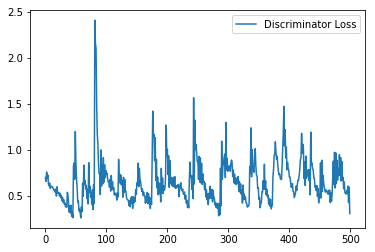

In [32]:
d_losses = mnist_dcgan.disc_losses
g_losses = mnist_dcgan.gen_losses

plt.plot(range(steps), d_losses, label="Discriminator Loss")
plt.plot(range(steps), g_losses, label="Generator Loss")
plt.legend()
plt.show()

In [24]:
new_mols = []

for line in GENERATED:
    for sample in line:
        new = sample[:11, :23].reshape((11, 23))
        new_mols.append(new)
        
found = set()

for mol in new_mols:
    s = convert_to_string(mol)
    if s not in found:
        found.add(s)
        print(s)
        
f = open("epochs_" + str(steps) + "_rms_8.txt", "+w")
for item in found:
    f.write(item)
    f.write("\n")
f.close()

CCCCCCCCCCCCCCCCCCCCCCC
